# Máquinas de Vectores de Soporte Regresión (SVM)

## 1. Librerias y configuraciones previas


In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np



# Almacenar en caché los resultados de funciones en el disco
# ==============================================================================
import joblib


# Gestion de librerias
# ==============================================================================
from importlib import reload


# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from scipy import stats
import math

#Separar los datos entrenamiento y prueba
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate


#Escalar Variables
from sklearn.preprocessing import MinMaxScaler

#Evaluación del modelo
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

#Creación de modelo
from sklearn.svm import SVR

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## 2. Funciones

In [2]:
#reload(utils.funciones)

# Funciones externas
# ==============================================================================
from funciones import multiple_plot

## 3. Carga del dataset

In [3]:
#Se crea un dataframe d con los datos obtenidos de archivo de entrada
d=pd.read_csv('/content/gemstone_Prep.csv')

In [4]:
## Cargar datos con colab
## =============================================================================

#from google.colab import drive
#import os

#drive.mount('/gdrive')

In [5]:
#os.chdir("/gdrive/MyDrive/ModelosCuantitativosPython/Notebooks")
#!ls

In [6]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20375 entries, 0 to 20374
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    20375 non-null  float64
 1   depth    20375 non-null  float64
 2   table    20375 non-null  float64
 3   x        20375 non-null  float64
 4   y        20375 non-null  float64
 5   z        20375 non-null  float64
 6   price    20375 non-null  float64
 7   cut      20375 non-null  object 
 8   color    20375 non-null  object 
 9   clarity  20375 non-null  object 
dtypes: float64(7), object(3)
memory usage: 1.6+ MB


In [7]:
d.columns

Index(['carat', 'depth', 'table', 'x', 'y', 'z', 'price', 'cut', 'color',
       'clarity'],
      dtype='object')

In [8]:
#d = d[["overall", "movement_reactions", "wage_eur"]].copy()

#d.info()

## 4. Visualización de datos

### Variables de entrada

In [9]:
#Lista de variables categóricas
catCols = d.select_dtypes(include = ["object", 'category']).columns.tolist()

d[catCols].head(2)

,cut,color,clarity
0,Very Good,H,SI1
1,Ideal,G,SI2


In [10]:
#Lista de variables numéricas

numCols=d.select_dtypes(include = ['float64','float64','int32','int64']).columns.tolist()
d[numCols].head(2)

,carat,depth,table,x,y,z,price
0,0.72,63.7,57.0,5.66,5.70,3.62,2168.0
1,1.16,61.3,55.0,6.79,6.84,4.18,4425.0


In [11]:
##Visualización de frecuencia de instancias para variables categóricas
#multiple_plot(3, d , catCols, None, 'countplot', 'Frecuencia de instancias para variables categóricas',30)

In [12]:
#Visualización por medio de gráficos de caja de bigotes para las variables categóricas con respecto al precio
#multiple_plot(3, d , catCols, 'Price', 'boxplot', 'Distribución de la variable Make vs. el Price',30)

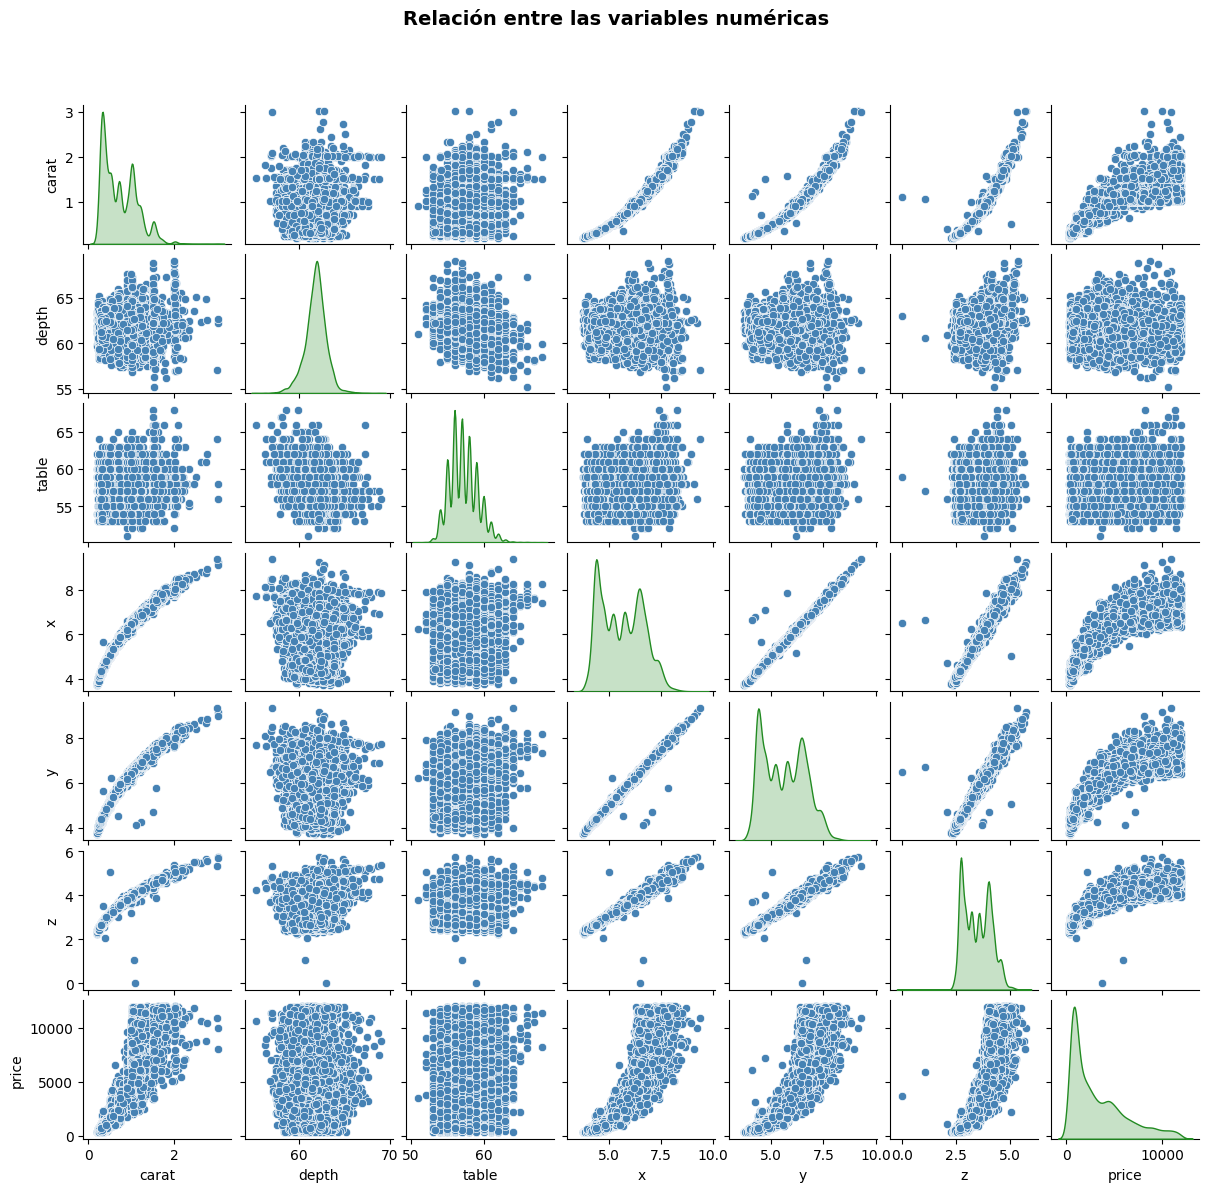

In [13]:
#Visualización de variables numéricas con respecto al precio
multiple_plot(1, d , numCols, None, 'scatterplot', 'Relación entre las variables numéricas',30)

In [14]:
#Eliminar la variable de salida de la lista de variable numéricas
numCols.remove('price')

### Variable de salida

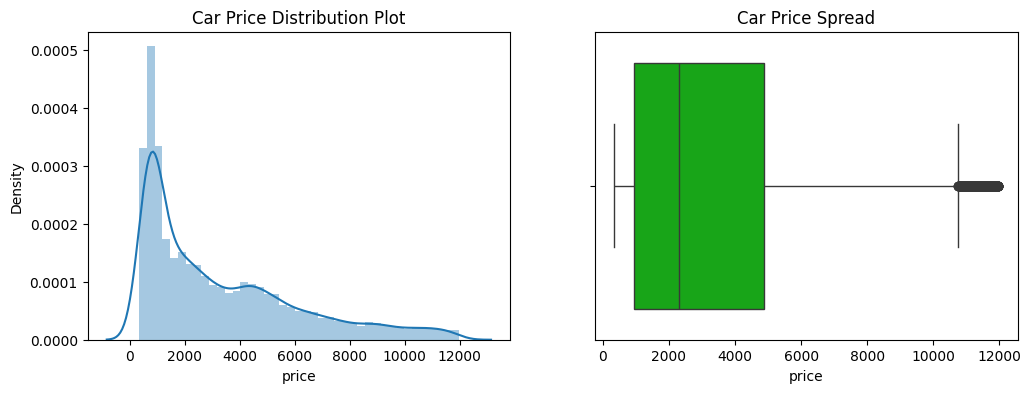

In [15]:
#Histográma y caja de bigotes del precio de los vehículos

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title('Car Price Distribution Plot')
sns.distplot(d.price)

plt.subplot(1,2,2)
plt.title('Car Price Spread')
sns.boxplot(x=d.price, palette='nipy_spectral')

plt.show()

In [16]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

print(d.price.describe(percentiles = [0.25,0.50,0.75,0.85,0.90,0.95,0.975,1]))

count   20375
mean     3288
std      2837
min       337
25%       932
50%      2313
75%      4864
85%      6416
90%      7640
95%      9432
97.5%   10640
100%    11971
max     11971
Name: price, dtype: float64


## 5. Preparación de datos

### Creación de Variables Dummies

In [17]:
# Aplicación de la función de usuario Dummies: one-hot encoding

d =pd.get_dummies(d, drop_first=1)

In [18]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20375 entries, 0 to 20374
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   carat          20375 non-null  float64
 1   depth          20375 non-null  float64
 2   table          20375 non-null  float64
 3   x              20375 non-null  float64
 4   y              20375 non-null  float64
 5   z              20375 non-null  float64
 6   price          20375 non-null  float64
 7   cut_Good       20375 non-null  bool   
 8   cut_Ideal      20375 non-null  bool   
 9   cut_Premium    20375 non-null  bool   
 10  cut_Very Good  20375 non-null  bool   
 11  color_E        20375 non-null  bool   
 12  color_F        20375 non-null  bool   
 13  color_G        20375 non-null  bool   
 14  color_H        20375 non-null  bool   
 15  color_I        20375 non-null  bool   
 16  color_J        20375 non-null  bool   
 17  clarity_IF     20375 non-null  bool   
 18  clarit

## 6. Creación del modelo

### Dividir el conjunto de datos

In [19]:
#Se establece las variables de entrada 'X' y la variable de salida 'y'

X = d.drop(columns = "price")
y = d['price']

In [20]:
# División de los datos en train y test

#En este caso, el 80% de los datos se utilizarán para entrenar el modelo.

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

### Escalar Variables

In [21]:
#Se establecen las variables numéricas a escalar

#Num_vars se le asigna la lista con las variables numerivas para posteriormente escalarlas
num_vars = numCols

print(num_vars)

['carat', 'depth', 'table', 'x', 'y', 'z']


In [22]:
#Escalar Variables númericas

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Se crea un objeto MinMaxScaler
scaler = MinMaxScaler()

# Se escalan los valores del dataset entrenamiento y prueba de las columnas numéricas
X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
X_test[num_vars] = scaler.transform(X_test[num_vars])

X_train[num_vars].head(2)

,carat,depth,table,x,y,z
14700,0.1210,0.4519,0.2353,0.2642,0.2804,0.5620
11363,0.3737,0.6000,0.2824,0.5479,0.5643,0.7574


### Creación del modelo

**Parámetros importantes**

- **C** (default = 1.0): Parámetro de regularización. La fuerza de la regularización es inversamente proporcional a C.Debe ser estrictamente positiva.La penalización es una penalización l2 al cuadrado. Un valor alto de C dará como resultado un modelo más complejo que se ajusta muy bien a los datos de entrenamiento pero puede tener problemas de sobreajuste (overfitting) en datos nuevos.

    
- **kernel** (default=’rbf’):
Especifica el tipo de kernel que se utilizará en el algoritmo. Debe ser ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ o invocable.


- **degreeint** (default=3)
Grado de la función del núcleo polinomial ('poly'). Ignorado por todos los demás núcleos.
   

- **gamma** {‘scale’, ‘auto’} or float, default=’scale’
Coeficiente de kernel para 'rbf', 'poli' y 'sigmoide'. ‘rbf’, ‘poly’ and ‘sigmoid’.

    - Si 'scale' usa 1 / (n_features * X.var())

    - Si ‘auto’ usa 1 / n_features.

- **epsilon** {default=0.1} controla el ancho de la zona de tolerancia alrededor de la línea de regresión. Los puntos que caen dentro de esta zona no son considerados errores de predicción.





### Método de retención (*holdout method*)

In [23]:
SVMR_linear    = SVR(kernel='linear' , C = 1000)
SVMR_Pol2   = SVR(kernel='poly'   , C = 1000, degree = 2)
SVMR_Pol3   = SVR(kernel='poly'   , C = 1000, degree = 3)
SVMR_rbf   = SVR(kernel='rbf'    , C = 1000)
SVMR_sig   = SVR(kernel='sigmoid', C = 1000)


SVMR_linear.fit(X_train, y_train)
SVMR_Pol2.fit(X_train, y_train)
SVMR_Pol3.fit(X_train, y_train)
SVMR_rbf.fit(X_train, y_train)
SVMR_sig.fit(X_train, y_train)


SVR(C=1000, kernel='sigmoid')

### Evaluación del modelo

In [24]:
print('Linear   Training: ', SVMR_linear.score(X_train,y_train), 'Test:',r2_score(y_test,SVMR_linear.predict(X_test)))
print('Poly 2   Training: ', SVMR_Pol2.score(X_train,y_train), 'Test:',r2_score(y_test,SVMR_Pol2.predict(X_test)))
print('Poly 3   Training: ', SVMR_Pol3.score(X_train,y_train), 'Test:',r2_score(y_test,SVMR_Pol3.predict(X_test)))
print('rbf      Training: ', SVMR_rbf.score(X_train,y_train), 'Test:',r2_score(y_test,SVMR_rbf.predict(X_test)))
print('sigmoide Training: ', SVMR_sig.score(X_train,y_train), 'Test:',r2_score(y_test,SVMR_sig.predict(X_test)))


Linear   Training:  0.9031911456598918 Test: 0.9067896473312216
Poly 2   Training:  0.9520807592806946 Test: 0.9511364127489986
Poly 3   Training:  0.9671111043883618 Test: 0.9657175615798522
rbf      Training:  0.9579044495924918 Test: 0.9551210710498585
sigmoide Training:  -1022.6441184301103 Test: -1041.853978699482


## 7. Afinando el modelo (tuning)

### Preparacion de datos

In [25]:
# Nuevamente se asigna a 'X_Completo' y 'y_Completo' los datos entrada y salida respectivamente
X_Completo = X
y_Completo = y

# Se escalan los datos numéricos de entrada
X_Completo[num_vars] = scaler.fit_transform(X_Completo[num_vars])

In [26]:
# Guardar el scaler
joblib.dump(scaler, 'minmaxFull_gemstone.pkl')

['minmaxFull_gemstone.pkl']

In [27]:
X_Completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20375 entries, 0 to 20374
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   carat          20375 non-null  float64
 1   depth          20375 non-null  float64
 2   table          20375 non-null  float64
 3   x              20375 non-null  float64
 4   y              20375 non-null  float64
 5   z              20375 non-null  float64
 6   cut_Good       20375 non-null  bool   
 7   cut_Ideal      20375 non-null  bool   
 8   cut_Premium    20375 non-null  bool   
 9   cut_Very Good  20375 non-null  bool   
 10  color_E        20375 non-null  bool   
 11  color_F        20375 non-null  bool   
 12  color_G        20375 non-null  bool   
 13  color_H        20375 non-null  bool   
 14  color_I        20375 non-null  bool   
 15  color_J        20375 non-null  bool   
 16  clarity_IF     20375 non-null  bool   
 17  clarity_SI1    20375 non-null  bool   
 18  clarit

### Identificando los mejores hiperparámetros

In [28]:
#Se entena el modelo con múltiples hiperparámetros buscando el mejor

#Se crea una instancia de una SVR Regression
modelsvr = SVR()

CV = 5

#Se establecen los hiperparámetros para el Kernel lineal
#svm_linear = {'C': [100, 1000],
#              'kernel': ['linear']}

#Se establecen los hiperparámetros para el Kernel polinomico
svm_poly = {'C': [10, 20],
              'gamma': ['auto', 'scale'],
              'degree': [3],
              'kernel': ['poly']}

#Se establecen los hiperparámetros para los kernels rbf y sigmoid
svm_others = {'C': [10,20],
              'gamma': ['auto', 'scale'],
              'kernel': [ 'rbf']}

#Se unen todos los hiperparametros en una lista de diccionarios
parameters = [svm_poly, svm_others]


# Se define un GridSearchCV con una validacion cruzada de 10 pliegues y con todos los
#hierparametros establecidos anteriormente
grid_svr = GridSearchCV(modelsvr, param_grid=parameters, cv=CV, verbose=3)

#Se entrena el GridSearchCV anterior (2 min. aprox.) con los datos completos
grid_svr.fit(X_Completo,y_Completo)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END C=10, degree=3, gamma=auto, kernel=poly;, score=-0.083 total time=  21.0s
[CV 2/5] END C=10, degree=3, gamma=auto, kernel=poly;, score=-0.112 total time=  20.0s
[CV 3/5] END C=10, degree=3, gamma=auto, kernel=poly;, score=-0.137 total time=  22.0s
[CV 4/5] END C=10, degree=3, gamma=auto, kernel=poly;, score=-0.095 total time=  20.9s
[CV 5/5] END C=10, degree=3, gamma=auto, kernel=poly;, score=-0.104 total time=  19.4s
[CV 1/5] END C=10, degree=3, gamma=scale, kernel=poly;, score=0.886 total time=  22.0s
[CV 2/5] END C=10, degree=3, gamma=scale, kernel=poly;, score=0.878 total time=  18.1s
[CV 3/5] END C=10, degree=3, gamma=scale, kernel=poly;, score=0.882 total time=  19.4s
[CV 4/5] END C=10, degree=3, gamma=scale, kernel=poly;, score=0.873 total time=  18.0s
[CV 5/5] END C=10, degree=3, gamma=scale, kernel=poly;, score=0.874 total time=  19.3s
[CV 1/5] END C=20, degree=3, gamma=auto, kernel=poly;, score=-0.070 to

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [10, 20], 'degree': [3],
                          'gamma': ['auto', 'scale'], 'kernel': ['poly']},
                         {'C': [10, 20], 'gamma': ['auto', 'scale'],
                          'kernel': ['rbf']}],
             verbose=3)

In [ ]:
#grid_svr.cv_results_

In [29]:
# Obtener los resultados del grid search
results_grid_svr = pd.DataFrame(grid_svr.cv_results_)


# Seleccionar las columnas deseadas
columns_grid_svr = ['param_C']  + \
                    ['param_degree']  + \
                    ['param_kernel']  + \
                    ['param_gamma']   + \
                    ['mean_test_score', 'std_test_score']  + \
                    [f'split{i}_test_score' for i in range(CV)]

# Filtrar y mostrar los resultados
results_grid_svr_filtered = results_grid_svr[columns_grid_svr]

# Crear la columna scoreWithStd: f1 / std
results_grid_svr_filtered['scoreWithStd'] = results_grid_svr_filtered.apply(
    lambda row: row['mean_test_score'] / row['std_test_score'] if row['std_test_score'] != 0 else 0,
    axis=1
)

# Encuentra el índice del máximo valor en la columna scoreWithStd
indice_max_scoreWithStd = results_grid_svr_filtered['scoreWithStd'].idxmax()

# Mostrar los scores promedios por cada parámetro
print(results_grid_svr_filtered[['param_C', 'param_degree', 'mean_test_score', 'std_test_score', 'scoreWithStd']])


  param_C param_degree  mean_test_score  std_test_score  scoreWithStd
0      10            3          -0.1064          0.0181       -5.8661
1      10            3           0.8786          0.0049      178.0853
2      20            3          -0.0942          0.0182       -5.1752
3      20            3           0.9103          0.0056      161.1171
4      10          NaN           0.3637          0.0155       23.4763
5      10          NaN           0.5705          0.0122       46.5777
6      20          NaN           0.5742          0.0117       49.1881
7      20          NaN           0.7179          0.0094       76.2638


In [30]:
# Se identifican los mejores hiperparámetros
best_params = grid_svr.best_params_
print('Best Parameters : ',best_params)

Best Parameters :  {'C': 20, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}


In [31]:
# Top 3 de los mejores scores
results_grid_svr_filtered.sort_values(by='scoreWithStd', ascending=False).head(3)[
    ['param_C', 'param_degree', 'param_kernel','param_gamma','mean_test_score', 'std_test_score', 'scoreWithStd']]

,param_C,param_degree,param_kernel,param_gamma,mean_test_score,std_test_score,scoreWithStd
1,10,3,poly,scale,0.8786,0.0049,178.0853
3,20,3,poly,scale,0.9103,0.0056,161.1171
7,20,NaN,rbf,scale,0.7179,0.0094,76.2638


In [32]:
# Seleccionar el registro correspondiente al índice máximo
registro_max_scoreWithStd = results_grid_svr_filtered.loc[indice_max_scoreWithStd]

registro_max_scoreWithStd.transpose()

param_C                   10
param_degree               3
param_kernel            poly
param_gamma            scale
mean_test_score       0.8786
std_test_score        0.0049
split0_test_score     0.8858
split1_test_score     0.8785
split2_test_score     0.8823
split3_test_score     0.8727
split4_test_score     0.8739
scoreWithStd        178.0853
Name: 1, dtype: object

In [33]:
results_grid_svr_filtered.loc[indice_max_scoreWithStd]['mean_test_score']

0.8786257902696712

### Creación del modelo final

In [ ]:
# Usar los mejores parámetros para crear el modelo
#modelsvr.set_params(**best_params)

#modelsvr.fit(X_Completo, y_Completo)

In [34]:
# Se crea un modelo SVR con los mejores hiperparámetros
modelsvr = SVR( kernel = best_params["kernel"]
                    , gamma = best_params["gamma"]
                    , C= best_params["C"]
                    , degree = best_params["degree"])


#Se entrena el modelo con los datos completos
modelsvr.fit(X_Completo, y_Completo)

SVR(C=20, kernel='poly')

### Guardar modelo

In [ ]:
#Se guardan los modelos de SVC

joblib.dump(modelsvr, 'SVR_CV_poly_gemstone.pkl')

['SVR_CV_poly_gemstone.pkl']

#### Referencias


- *Machine learning con Python y Scikit-learn:*
    - https://www.cienciadedatos.net/documentos/py06_machine_learning_python_scikitlearn.html
    

- *scikit-learn:*    
    - https://scikit-learn.org/stable/
    - https://scikit-learn.org/stable/user_guide.html
  
  
- *Gráficas con  seaborn:*
    - https://ichi.pro/es/como-utilizar-python-seaborn-para-analisis-de-datos-exploratorios-28897898172180





- *Analítica de grandes datos:*
    - https://jdvelasq.github.io/courses/analitica-de-grandes-datos/index.html

# ArbolesDecisionRegresion

In [35]:
#Creación de modelo
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

**Parámetros importantes**


- **criterion** {‘squared_error’, ‘friedman_mse’, ‘absolute_error’, ‘poisson’}, default=‘squared_error’
Función para medir la calidad de la división utlizando el criterio definido como parametro ‘squared_error’, ‘friedman_mse’, ‘absolute_error’ o ‘poisson’


- **max_depth** {int, default=None}: Profundidad máxima del árbol. Si se establece en None, se expanden todos los nodos hasta que todas las hojas contengan menos de min_samples_split muestras.


- **min_samples_split** {int or float, default=2}: número mínimo de muestras requeridas para dividir un nodo interno.


- **min_samples_leaf** {int or float, default=1}: número mínimo de muestras requeridas en cada hoja.


- **max_features** {int, float or {“auto”, “sqrt”, “log2”}, default=None}: número máximo de características a considerar cuando se busca la mejor división.

In [36]:
# Creación del modelo
# ------------------------------------------------------------------------------
dTreeR = DecisionTreeRegressor(
            max_depth         = 3,
            random_state      = 123
          )

# Entrenamiento del modelo
# ------------------------------------------------------------------------------
dTreeR.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3, random_state=123)

In [37]:
print('Training:', dTreeR.score(X_train,y_train))
print('Test    :',r2_score(y_test,dTreeR.predict(X_test)))

Training: 0.8722144098768241
Test    : 0.8687324102596964


Profundidad del árbol: 3
Número de nodos terminales: 8


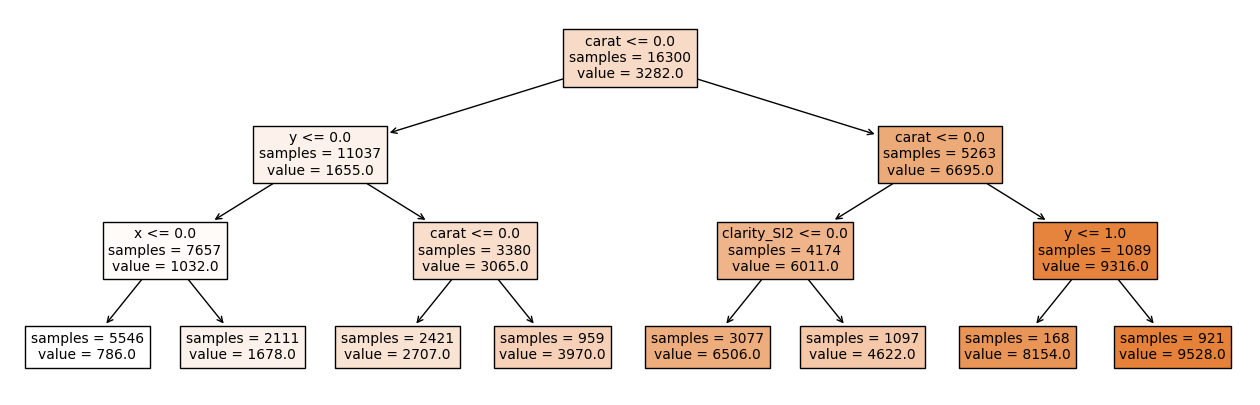

In [38]:
# Estructura del árbol creado
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(16, 5))

print(f"Profundidad del árbol: {dTreeR.get_depth()}")
print(f"Número de nodos terminales: {dTreeR.get_n_leaves()}")

plot = plot_tree(
            decision_tree = dTreeR,
            feature_names = d.drop(columns = "price").columns,
            class_names   = 'price',
            filled        = True,
            impurity      = False,
            fontsize      = 10,
            precision     = 0,
            ax            = ax
       )

## Afinando el modelo (tuning)

In [40]:
#Se entena el modelo con múltiples hiperparámetros buscando el mejor

#Se crea una instancia de una DecisionTreeRegressor
modelTreeR = DecisionTreeRegressor()

CV = 5

#Se establecen los hiperparámetros
parameters = {'max_depth': [2, 4, 6, 8, 10],
              'min_samples_split': [15, 30, 45, 60],
              'min_samples_leaf' : [15, 30, 45, 60],
              'max_features' : ['auto', 'sqrt', 'log2']
             }

# Se define un GridSearchCV con una validacion cruzada de 10 pliegues y con todos los
#hierparametros establecidos anteriormente
grid_TreeR = GridSearchCV(
                          modelTreeR,
                          param_grid=parameters,
                          cv=CV,
                          verbose=3)

#Se entrena el GridSearchCV anterior (2 min. aprox.) con los datos completos
grid_TreeR.fit(X_Completo,y_Completo)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV 1/5] END max_depth=2, max_features=auto, min_samples_leaf=15, min_samples_split=15;, score=0.836 total time=   0.0s
[CV 2/5] END max_depth=2, max_features=auto, min_samples_leaf=15, min_samples_split=15;, score=0.820 total time=   0.0s
[CV 3/5] END max_depth=2, max_features=auto, min_samples_leaf=15, min_samples_split=15;, score=0.819 total time=   0.0s
[CV 4/5] END max_depth=2, max_features=auto, min_samples_leaf=15, min_samples_split=15;, score=0.824 total time=   0.0s
[CV 5/5] END max_depth=2, max_features=auto, min_samples_leaf=15, min_samples_split=15;, score=0.815 total time=   0.0s
[CV 1/5] END max_depth=2, max_features=auto, min_samples_leaf=15, min_samples_split=30;, score=0.836 total time=   0.0s
[CV 2/5] END max_depth=2, max_features=auto, min_samples_leaf=15, min_samples_split=30;, score=0.820 total time=   0.0s
[CV 3/5] END max_depth=2, max_features=auto, min_samples_leaf=15, min_samples_split=30;, score=0

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [2, 4, 6, 8, 10],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [15, 30, 45, 60],
                         'min_samples_split': [15, 30, 45, 60]},
             verbose=3)

In [41]:
# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid_TreeR.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,mean_test_score,std_test_score
192,10,auto,15,15,0.9436,0.0051
193,10,auto,15,30,0.9436,0.0051
194,10,auto,15,45,0.9433,0.0051
195,10,auto,15,60,0.9431,0.0052


In [42]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)


# Obtener los resultados del grid search
results_grid_TreeR = pd.DataFrame(grid_TreeR.cv_results_)


# Seleccionar las columnas deseadas
columns_grid_TreeR = ['param_max_depth']  + \
                    ['param_min_samples_split']  + \
                    ['param_min_samples_leaf']  + \
                    ['param_max_features']   + \
                    ['mean_test_score', 'std_test_score']  + \
                    [f'split{i}_test_score' for i in range(CV)]

# Filtrar y mostrar los resultados
results_grid_TreeR_filtered = results_grid_TreeR[columns_grid_TreeR]

# Crear la columna scoreWithStd: f1 / std
results_grid_TreeR_filtered['scoreWithStd'] = results_grid_TreeR_filtered.apply(
    lambda row: row['mean_test_score'] / row['std_test_score'] if row['std_test_score'] != 0 else 0,
    axis=1
)

# Encuentra el índice del máximo valor en la columna scoreWithStd
indice_max_scoreWithStd = results_grid_TreeR_filtered['scoreWithStd'].idxmax()

# Mostrar los scores promedios por cada parámetro
results_grid_TreeR_filtered[['param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf','param_max_features','mean_test_score', 'std_test_score', 'scoreWithStd']]


,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_max_features,mean_test_score,std_test_score,scoreWithStd
0,2,15,15,auto,0.8226,0.0072,113.7434
1,2,30,15,auto,0.8226,0.0072,113.7434
2,2,45,15,auto,0.8226,0.0072,113.7434
3,2,60,15,auto,0.8226,0.0072,113.7434
4,2,15,30,auto,0.8226,0.0072,113.7434
...,...,...,...,...,...,...,...
235,10,60,45,log2,0.8993,0.0029,315.1820
236,10,15,60,log2,0.8848,0.0213,41.5913
237,10,30,60,log2,0.8907,0.0167,53.3639
238,10,45,60,log2,0.9048,0.0121,74.7738


In [43]:
# Se identifican los mejores hiperparámetros
best_params = grid_TreeR.best_params_
print('Best Parameters : ',best_params)

Best Parameters :  {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 15, 'min_samples_split': 15}


In [44]:
# Top 3 de los mejores scores
results_grid_TreeR_filtered.sort_values(by='scoreWithStd', ascending=False).head(3)[
    ['param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf','param_max_features','mean_test_score', 'std_test_score', 'scoreWithStd']]

,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_max_features,mean_test_score,std_test_score,scoreWithStd
235,10,60,45,log2,0.8993,0.0029,315.1820
182,8,45,30,log2,0.8999,0.0035,255.0477
150,8,45,30,auto,0.9283,0.0038,246.0835


In [45]:
# Seleccionar el registro correspondiente al índice máximo
registro_max_scoreWithStd = results_grid_TreeR_filtered.loc[indice_max_scoreWithStd]

registro_max_scoreWithStd.transpose()

param_max_depth                 10
param_min_samples_split         60
param_min_samples_leaf          45
param_max_features            log2
mean_test_score             0.8993
std_test_score              0.0029
split0_test_score           0.8984
split1_test_score           0.9017
split2_test_score           0.8944
split3_test_score           0.9024
split4_test_score           0.8997
scoreWithStd              315.1820
Name: 235, dtype: object

In [46]:
results_grid_TreeR_filtered.loc[indice_max_scoreWithStd]['mean_test_score']

0.8993185459892687

## Creacion del modelo final

In [47]:
# Se crea un modelo árbol de decisión con los mejores hiperparámetros
modelTreeR = DecisionTreeRegressor( max_depth = best_params["max_depth"]
                               , min_samples_split = best_params["min_samples_split"]
                               , min_samples_leaf = best_params["min_samples_leaf"]
                               , max_features = best_params["max_features"]
                               , random_state = 1234)


#Se entrena el modelo con los datos completos
modelTreeR.fit(X_Completo, y_Completo)

DecisionTreeRegressor(max_depth=10, max_features='auto', min_samples_leaf=15,
                      min_samples_split=15, random_state=1234)

In [ ]:
# Se imprime el resultado que debe ser mejor que el inicial dado que se identificaron los mejores hiperparámetros

print(modelTreeR.score(X_Completo,y_Completo))

### Utilizando *ccp_alpha*

In [48]:
#Se crea una instancia de una DecisionTreeRegressor
modelTreeR_ccp = DecisionTreeRegressor( random_state = 123)


# Definir los parámetros para la búsqueda en la cuadrícula
parameters = {'ccp_alpha': np.logspace(-6, 2, 9)} # Valores entre 0.000001 y 100 en una escala logarítmica
#parameters = {'ccp_alpha': [0.000001]} # Valores entre 0.000001 y 100 en una escala logarítmica

# Definimos las metricas sobre las que queremos evaluar
metricas = 'f1'

# definicion de la variable con el número de pliegues
CV = 5

# Se define un GridSearchCV con una validacion cruzada de 10 pliegues y con todos los
#hierparametros establecidos anteriormente
grid_TreeR = GridSearchCV(
                          modelTreeR_ccp,
                          param_grid=parameters,
                          cv=CV,
                          verbose=3)

#Se entrena el GridSearchCV anterior (2 min. aprox.) con los datos completos
grid_TreeR.fit(X_Completo,y_Completo)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ...................ccp_alpha=1e-06;, score=0.947 total time=   0.4s
[CV 2/5] END ...................ccp_alpha=1e-06;, score=0.949 total time=   0.4s
[CV 3/5] END ...................ccp_alpha=1e-06;, score=0.951 total time=   0.4s
[CV 4/5] END ...................ccp_alpha=1e-06;, score=0.942 total time=   0.3s
[CV 5/5] END ...................ccp_alpha=1e-06;, score=0.953 total time=   0.2s
[CV 1/5] END ...................ccp_alpha=1e-05;, score=0.947 total time=   0.2s
[CV 2/5] END ...................ccp_alpha=1e-05;, score=0.949 total time=   0.1s
[CV 3/5] END ...................ccp_alpha=1e-05;, score=0.951 total time=   0.1s
[CV 4/5] END ...................ccp_alpha=1e-05;, score=0.942 total time=   0.1s
[CV 5/5] END ...................ccp_alpha=1e-05;, score=0.953 total time=   0.2s
[CV 1/5] END ..................ccp_alpha=0.0001;, score=0.947 total time=   0.2s
[CV 2/5] END ..................ccp_alpha=0.0001;,

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=123),
             param_grid={'ccp_alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02])},
             verbose=3)

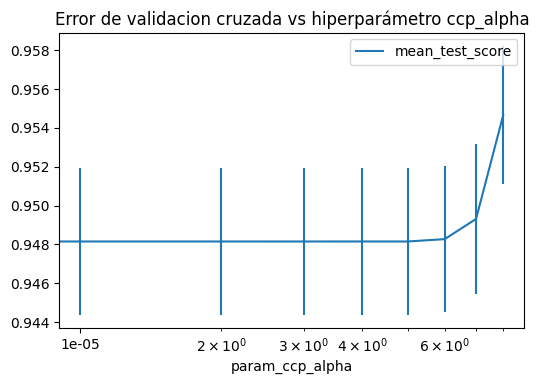

In [49]:
fig, ax = plt.subplots(figsize=(6, 3.84))
scores = pd.DataFrame(grid_TreeR.cv_results_)

# Variacion de ccp_alpha
ax.set_xscale('log')
scores.plot(x='param_ccp_alpha', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.set_title("Error de validacion cruzada vs hiperparámetro ccp_alpha");

In [50]:
# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid_TreeR.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(10)

,param_ccp_alpha,mean_test_score,std_test_score
8,100.0000,0.9546,0.0036
7,10.0000,0.9493,0.0039
6,1.0000,0.9483,0.0038
4,0.0100,0.9482,0.0038
0,0.0000,0.9482,0.0038
1,0.0000,0.9482,0.0038
2,0.0001,0.9482,0.0038
5,0.1000,0.9482,0.0038
3,0.0010,0.9482,0.0038


In [51]:
# Mejor valor ccp_alpha encontrado
# ------------------------------------------------------------------------------
grid_TreeR.best_params_

{'ccp_alpha': 100.0}

In [52]:
# Estructura del árbol final
# ------------------------------------------------------------------------------
modelTreeR_ccp = grid_TreeR.best_estimator_
print(f"Profundidad del árbol: {modelTreeR.get_depth()}")
print(f"Número de nodos terminales: {modelTreeR.get_n_leaves()}")
print(f"Score: {grid_TreeR.best_score_}")

Profundidad del árbol: 10
Número de nodos terminales: 355
Score: 0.9546440923172016


### Creación del modelo final

In [53]:
# Creación del modelo
# ------------------------------------------------------------------------------
modelTreeR_ccp = DecisionTreeRegressor(
            ccp_alpha         = grid_TreeR.best_params_["ccp_alpha"],
            random_state      = 123
          )

# Entrenamiento del modelo
# ------------------------------------------------------------------------------
modelTreeR_ccp.fit(X_Completo, y_Completo)

DecisionTreeRegressor(ccp_alpha=100.0, random_state=123)

### Guardar modelo

In [54]:
#Se guardan los modelos de árboles
joblib.dump(modelTreeR, 'DTreeR_CV_gemstone.pkl')
joblib.dump(modelTreeR_ccp, 'DTreeR_CV_ccp_gemstone.pkl')

['DTreeR_CV_ccp_gemstone.pkl']

# Árboles de Decisión Random Forest (Regresión)

In [56]:
#creación de modelos
from sklearn.ensemble import RandomForestRegressor

Un Random Forest es un metaestimador que ajusta una serie de árboles de decisión de clasificación en varias submuestras del conjunto de datos y utiliza el promedio para mejorar la precisión predictiva y controlar el sobreajuste.

**Parametros:**
- **n_estimators:** (default=100) número de árboles del bosque
- **max_depth:** (default=None) La profundidad máxima del árbol. Si es `None`, los nodos se expanden hasta que todas las hojas sean puras o hasta que todas las hojas contengan menos ejemplos del parametro min_samples_split.
- **max_features:** (default=1.0) El número de características a considerar al buscar la mejor división
    - auto, None o 1.0: max_features=n_features.
    - sqrt: max_features=sqrt(n_features).
    - log2: max_features=log2(n_features).

- **bootstrap:**(default=True) Si se utilizan muestras al construir árboles. Si es False, se usa todo el conjunto de datos para construir cada árbol.

- **oob_score:** (default=False) si usa ejemplos out-of-bag para estimar un score de generalización. Solo disponible si bootstrap = True.

In [57]:
# Creación del modelo
# ==============================================================================
modelRF = RandomForestRegressor(
            n_estimators = 10,
            criterion    = 'squared_error',
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,   #out-of-bag samples
            n_jobs       = -1,
            random_state = 123
         )


# Entrenamiento del modelo
# ==============================================================================
modelRF.fit(X_train, y_train)

RandomForestRegressor(max_features='auto', n_estimators=10, n_jobs=-1,
                      random_state=123)

### Evaluación del modelo

#### Error Cuadráico Medio (rmse) y el Coeficiente de Determinación $R^2$

In [58]:
# Error de test del modelo inicial
# ==============================================================================
predicciones = modelRF.predict(X = X_test)

rmse = mean_squared_error(y_true  = y_test, y_pred  = predicciones, squared = False)
print(f"El error (rmse) de test es: {rmse}")

r2 = r2_score(y_test, predicciones)
print(f"El error (r2) de test es: {r2}")

El error (rmse) de test es: 482.7629853625421
El error (r2) de test es: 0.9702781490438123


## Afinando el modelo (tuning)

Valor óptimo de n_estimators(árboles): 96


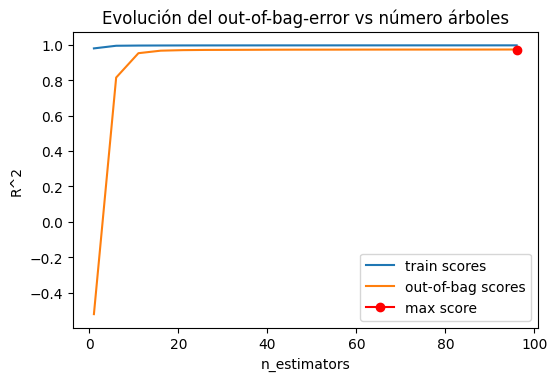

In [59]:
# Validación empleando el Out-of-Bag error :

# ==============================================================================
train_scores = []
oob_scores   = []

# Valores evaluados
estimator_range = range(1, 100, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de Out-of-Bag.

for n_estimators in estimator_range:

    modelRF = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error', #mean squared error
                max_depth    = None,
                max_features = 'auto',
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelRF.fit(X_Completo, y_Completo)
    train_scores.append(modelRF.score(X_Completo, y_Completo))
    oob_scores.append(modelRF.oob_score_)



# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators(árboles): {estimator_range[np.argmax(oob_scores)]}")

Valor óptimo de n_estimators: 96


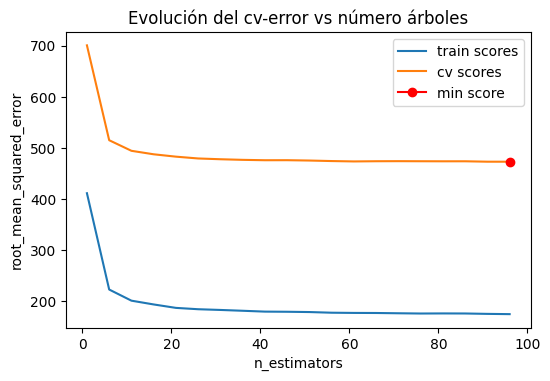

In [60]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
estimator_range = range(1, 100, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de k-cross-validation.
for n_estimators in estimator_range:

    modelRF = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error', #mean squared error: mse
                max_depth    = None,
                max_features = 'auto',
                oob_score    = False,
                n_jobs       = -1,
                random_state = 123
             )

    # Error de train
    modelRF.fit(X_Completo, y_Completo)
    predicciones = modelRF.predict(X = X_Completo)
    rmse = mean_squared_error(
            y_true  = y_Completo,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)

    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelRF,
                X         = X_Completo,
                y         = y_Completo,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())

# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.plot(estimator_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del cv-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmin(cv_scores)]}")

In [61]:
from sklearn.model_selection import ParameterGrid
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [15, 20, 25],
                 'max_features': [7, 9, 11, 12],
                 'max_depth'   : [3, 10, 20]
                }
             )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_r2': []}

for params in param_grid:

    modelRF = RandomForestRegressor(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )

    modelRF.fit(X_Completo, y_Completo)

    resultados['params'].append(params)
    resultados['oob_r2'].append(modelRF.oob_score_)
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_r2', ascending=False)
resultados.head(5)

Modelo: {'max_depth': 3, 'max_features': 7, 'n_estimators': 15} ✓
Modelo: {'max_depth': 3, 'max_features': 7, 'n_estimators': 20} ✓
Modelo: {'max_depth': 3, 'max_features': 7, 'n_estimators': 25} ✓
Modelo: {'max_depth': 3, 'max_features': 9, 'n_estimators': 15} ✓
Modelo: {'max_depth': 3, 'max_features': 9, 'n_estimators': 20} ✓
Modelo: {'max_depth': 3, 'max_features': 9, 'n_estimators': 25} ✓
Modelo: {'max_depth': 3, 'max_features': 11, 'n_estimators': 15} ✓
Modelo: {'max_depth': 3, 'max_features': 11, 'n_estimators': 20} ✓
Modelo: {'max_depth': 3, 'max_features': 11, 'n_estimators': 25} ✓
Modelo: {'max_depth': 3, 'max_features': 12, 'n_estimators': 15} ✓
Modelo: {'max_depth': 3, 'max_features': 12, 'n_estimators': 20} ✓
Modelo: {'max_depth': 3, 'max_features': 12, 'n_estimators': 25} ✓
Modelo: {'max_depth': 10, 'max_features': 7, 'n_estimators': 15} ✓
Modelo: {'max_depth': 10, 'max_features': 7, 'n_estimators': 20} ✓
Modelo: {'max_depth': 10, 'max_features': 7, 'n_estimators': 25} ✓
M

,oob_r2,max_depth,max_features,n_estimators
35,0.9694,20,12,25
32,0.9689,20,11,25
34,0.9680,20,12,20
29,0.9677,20,9,25
31,0.9672,20,11,20


In [62]:
# Mejores hiperparámetros por out-of-bag error
# ==============================================================================
print("--------------------------------------------")
print("Mejores hiperparámetros encontrados (oob-r2)")
print("--------------------------------------------")
print(resultados.iloc[0,:]['oob_r2'], "R2")

--------------------------------------------
Mejores hiperparámetros encontrados (oob-r2)
--------------------------------------------
0.9693971128624884 R2


#### Validación Cruzada

In [63]:
#Se entrena el modelo con múltiples hiperparámetros buscando el mejor


# Definir el modelo AdaBoostRegressor
modelRF = RandomForestRegressor(random_state = 123)


CV = 10


parameters =  {
                'n_estimators': [15, 20, 25],
                'max_features': [9, 10, 11, 12],
                'max_depth'   : [3, 10, 20]
                }

grid_RF = GridSearchCV(
                    estimator  = modelRF,
                    param_grid = parameters,
                    scoring    =  'r2',         #'neg_root_mean_squared_error',
                    n_jobs     = - 1,
                    cv         = CV,
                    refit      = True,
                    verbose    = 3,
                    return_train_score = True
                   )

grid_RF.fit(X = X_Completo, y = y_Completo)


Fitting 10 folds for each of 36 candidates, totalling 360 fits


GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=123),
             n_jobs=-1,
             param_grid={'max_depth': [3, 10, 20],
                         'max_features': [9, 10, 11, 12],
                         'n_estimators': [15, 20, 25]},
             return_train_score=True, scoring='r2', verbose=3)

In [64]:
# Resultados
resultados = pd.DataFrame(grid_RF.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
35,20,12,25,0.9719,0.0033,0.9948,0.0001
34,20,12,20,0.9713,0.0033,0.9946,0.0001
32,20,11,25,0.9712,0.0032,0.9947,0.0001
31,20,11,20,0.9708,0.0032,0.9945,0.0001


In [65]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)


# Obtener los resultados del grid search
results_grid_RF = pd.DataFrame(grid_RF.cv_results_)


# Seleccionar las columnas deseadas
columns_grid_RF = ['param_max_depth']  + \
                    ['param_max_features']  + \
                    ['param_n_estimators']  + \
                    ['mean_test_score', 'std_test_score']  + \
                    [f'split{i}_test_score' for i in range(CV)]

# Filtrar y mostrar los resultados
results_grid_RF_filtered = results_grid_RF[columns_grid_RF]

# Crear la columna scoreWithStd: f1 / std
results_grid_RF_filtered['scoreWithStd'] = results_grid_RF_filtered.apply(
    lambda row: row['mean_test_score'] / row['std_test_score'] if row['std_test_score'] != 0 else 0,
    axis=1
)

# Encuentra el índice del máximo valor en la columna scoreWithStd
indice_max_scoreWithStd = results_grid_RF_filtered['scoreWithStd'].idxmax()

# Mostrar los scores promedios por cada parámetro
results_grid_RF_filtered[['param_max_depth', 'param_max_features','param_n_estimators', 'mean_test_score', 'std_test_score', 'scoreWithStd']]


,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,scoreWithStd
0,3,9,15,0.8741,0.0078,112.5741
1,3,9,20,0.8732,0.0077,113.0459
2,3,9,25,0.8730,0.0077,113.5997
3,3,10,15,0.8745,0.0084,103.9031
4,3,10,20,0.8738,0.0086,101.4915
5,3,10,25,0.8746,0.0086,101.5832
6,3,11,15,0.8733,0.0090,97.3917
7,3,11,20,0.8742,0.0092,95.4377
8,3,11,25,0.8756,0.0091,96.1154
9,3,12,15,0.8734,0.0074,117.3693


In [66]:
# Se identifican los mejores hiperparámetros
best_params = grid_RF.best_params_
print('Best Parameters : ',best_params)

Best Parameters :  {'max_depth': 20, 'max_features': 12, 'n_estimators': 25}


In [67]:
# Top 3 de los mejores scores
results_grid_RF_filtered.sort_values(by='scoreWithStd', ascending=False).head(3)[
    ['param_max_depth', 'param_max_features','param_n_estimators', 'mean_test_score', 'std_test_score', 'scoreWithStd']]

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,scoreWithStd
31,20,11,20,0.9708,0.0032,307.4552
32,20,11,25,0.9712,0.0032,307.0863
30,20,11,15,0.9703,0.0032,304.7083


In [68]:
# Seleccionar el registro correspondiente al índice máximo
registro_max_scoreWithStd = results_grid_RF_filtered.loc[indice_max_scoreWithStd]

registro_max_scoreWithStd.transpose()

param_max_depth            20
param_max_features         11
param_n_estimators         20
mean_test_score        0.9708
std_test_score         0.0032
split0_test_score      0.9762
split1_test_score      0.9712
split2_test_score      0.9709
split3_test_score      0.9711
split4_test_score      0.9724
split5_test_score      0.9736
split6_test_score      0.9677
split7_test_score      0.9693
split8_test_score      0.9640
split9_test_score      0.9720
scoreWithStd         307.4552
Name: 31, dtype: object

In [69]:
results_grid_RF_filtered.loc[indice_max_scoreWithStd]['mean_test_score']

0.9708320812839561

In [70]:
# Se crea un modelo árbol de decisión con los mejores hiperparámetros
modelRF = RandomForestRegressor( max_depth = best_params["max_depth"]
                               , max_features = best_params["max_features"]
                               , n_estimators = best_params["n_estimators"]
                               , random_state = 1234)


#Se entrena el modelo con los datos completos
modelRF.fit(X_Completo, y_Completo)

RandomForestRegressor(max_depth=20, max_features=12, n_estimators=25,
                      random_state=1234)

### Importancia de predictores

#### Importancia por pureza de nodos

In [71]:
importancia_predictores = pd.DataFrame(
                            {'predictor': d.drop(columns = "price").columns,
                             'importancia': modelRF.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
4,y,0.3601
0,carat,0.3267
3,x,0.1906
18,clarity_SI2,0.0223
17,clarity_SI1,0.0145
22,clarity_VVS2,0.0117
5,z,0.0114
15,color_J,0.0094
14,color_I,0.0072
21,clarity_VVS1,0.0065


### Guardar modelo

In [72]:
#Se guardan los modelos de árboles

joblib.dump(modelRF, 'RForest_CV_gemstone.pkl')

['RForest_CV_gemstone.pkl']

# AdaBoost (Regresion)

In [73]:
#creación de modelos
from sklearn.ensemble import AdaBoostRegressor

**Parámetros importantes**

- **n_estimators:** Especifica el número de estimadores (modelos base) en el conjunto de AdaBoost. Cuanto mayor sea el número de estimadores, más complejo será el modelo, pero también existe el riesgo de sobreajuste.

- **learning_rate:** Controla la contribución de cada estimador en el conjunto. Un valor más bajo reduce la influencia de cada estimador y puede mejorar la generalización del modelo.

- **base_estimator:** Especifica el estimador base utilizado en el conjunto. Por defecto, se utiliza DecisionTreeRegressor, pero también se puede especificar otro estimador de regresión.

- **random_state:** Controla la generación de números aleatorios para reproducibilidad.


In [74]:
# Crear y entrenar el modelo AdaBoost
model = AdaBoostRegressor(n_estimators=100, random_state=1)
model.fit(X_train, y_train)

AdaBoostRegressor(n_estimators=100, random_state=1)

### Evaluación del modelo

#### Error Cuadráico Medio (rmse) y el Coeficiente de Determinación $R^2$

In [75]:
# Error de test del modelo inicial
# ==============================================================================
predicciones = model.predict(X = X_test)

rmse = mean_squared_error(y_true  = y_test, y_pred  = predicciones, squared = False)
print(f"El error (rmse) de test es: {rmse}")

r2 = r2_score(y_test, predicciones)
print(f"El error (r2) de test es: {r2}")

El error (rmse) de test es: 995.3910369939236
El error (r2) de test es: 0.8736441437373079


### Afinando el modelo (tuning)

#### Identidicando los mejores hiperparametros

In [76]:
#Se entrena el modelo con múltiples hiperparámetros buscando el mejor


# Definir el modelo AdaBoostRegressor
modelAdaB = AdaBoostRegressor()


CV = 5

parameters = {'n_estimators': range(1, 100, 5),
             'learning_rate':[.001,0.01,.1]
             }

grid_AdaB = GridSearchCV(
                        estimator  = modelAdaB,
                        param_grid = parameters,
                        n_jobs     = - 1,
                        cv         = CV,
                        refit      = True,
                        verbose    = 3,
                        return_train_score = True
                       )

grid_AdaB.fit(X = X_Completo, y = y_Completo)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5, estimator=AdaBoostRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'n_estimators': range(1, 100, 5)},
             return_train_score=True, verbose=3)

In [77]:
# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid_AdaB.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_learning_rate,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
35,0.0100,76,0.8782,0.0048,0.8796,0.0015
34,0.0100,71,0.8781,0.0048,0.8797,0.0013
37,0.0100,86,0.8778,0.0053,0.8794,0.0017
36,0.0100,81,0.8778,0.0047,0.8795,0.0018


In [78]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)


# Obtener los resultados del grid search
results_grid_AdaB = pd.DataFrame(grid_AdaB.cv_results_)


# Seleccionar las columnas deseadas
columns_grid_AdaB = ['param_learning_rate']  + \
                    ['param_n_estimators']  + \
                    ['mean_test_score', 'std_test_score']  + \
                    [f'split{i}_test_score' for i in range(CV)]

# Filtrar y mostrar los resultados
results_grid_AdaB_filtered = results_grid_AdaB[columns_grid_AdaB]

# Crear la columna scoreWithStd: f1 / std
results_grid_AdaB_filtered['scoreWithStd'] = results_grid_AdaB_filtered.apply(
    lambda row: row['mean_test_score'] / row['std_test_score'] if row['std_test_score'] != 0 else 0,
    axis=1
)

# Encuentra el índice del máximo valor en la columna scoreWithStd
indice_max_scoreWithStd = results_grid_AdaB_filtered['scoreWithStd'].idxmax()

# Mostrar los scores promedios por cada parámetro
results_grid_AdaB_filtered[['param_learning_rate', 'param_n_estimators','mean_test_score', 'std_test_score', 'scoreWithStd']]


,param_learning_rate,param_n_estimators,mean_test_score,std_test_score,scoreWithStd
0,0.0010,1,0.8560,0.0074,116.0948
1,0.0010,6,0.8690,0.0099,87.4950
2,0.0010,11,0.8705,0.0065,133.6972
3,0.0010,16,0.8721,0.0063,137.6750
4,0.0010,21,0.8684,0.0085,102.7577
5,0.0010,26,0.8718,0.0058,150.9135
6,0.0010,31,0.8717,0.0069,126.9280
7,0.0010,36,0.8709,0.0064,135.5942
8,0.0010,41,0.8708,0.0076,114.8784
9,0.0010,46,0.8718,0.0055,157.9583


In [79]:
# Se identifican los mejores hiperparámetros
best_params = grid_AdaB.best_params_
print('Best Parameters : ',best_params)

Best Parameters :  {'learning_rate': 0.01, 'n_estimators': 76}


In [80]:
# Top 3 de los mejores scores
results_grid_AdaB_filtered.sort_values(by='scoreWithStd', ascending=False).head(3)[
    ['param_learning_rate', 'param_n_estimators','mean_test_score', 'std_test_score', 'scoreWithStd']]

,param_learning_rate,param_n_estimators,mean_test_score,std_test_score,scoreWithStd
45,0.1000,26,0.8768,0.0027,329.6443
32,0.0100,61,0.8765,0.0037,236.8938
21,0.0100,6,0.8648,0.0038,226.5763


In [81]:
# Seleccionar el registro correspondiente al índice máximo
registro_max_scoreWithStd = results_grid_AdaB_filtered.loc[indice_max_scoreWithStd]

registro_max_scoreWithStd.transpose()

param_learning_rate     0.1000
param_n_estimators          26
mean_test_score         0.8768
std_test_score          0.0027
split0_test_score       0.8815
split1_test_score       0.8759
split2_test_score       0.8764
split3_test_score       0.8733
split4_test_score       0.8768
scoreWithStd          329.6443
Name: 45, dtype: object

In [82]:
# Se crea un modelo árbol de decisión con los mejores hiperparámetros
modelAdaB = AdaBoostRegressor( n_estimators = best_params["n_estimators"]
                               , learning_rate = best_params["learning_rate"]
                               , random_state = 1234)


#Se entrena el modelo con los datos completos
modelAdaB.fit(X_Completo, y_Completo)

AdaBoostRegressor(learning_rate=0.01, n_estimators=76, random_state=1234)

In [83]:
# Se imprime el resultado que debe ser mejor que el inicial dado que se identificaron los mejores hiperparámetros

print(modelAdaB.score(X_Completo,y_Completo))

0.8787032715056146


## Guardar modelo

In [84]:
#Se guardan los modelos de SVC

joblib.dump(modelAdaB, 'ABoostR_CV_gemstone.pkl')

['ABoostR_CV_gemstone.pkl']

# Gradient Boosting (Regresion)

In [85]:
#creación de modelos
from sklearn.ensemble import GradientBoostingRegressor

In [86]:
# Crear y entrenar el Gradient Boosting
model = GradientBoostingRegressor(n_estimators=100, random_state=1)
model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=1)

### Evaluación del modelo

In [87]:
# Error de test del modelo inicial
# ==============================================================================
predicciones = model.predict(X = X_test)

rmse = mean_squared_error(y_true  = y_test, y_pred  = predicciones, squared = False)
print(f"El error (rmse) de test es: {rmse}")

r2 = r2_score(y_test, predicciones)
print(f"El error (r2) de test es: {r2}")

El error (rmse) de test es: 603.2526047271175
El error (r2) de test es: 0.9535905592483779


## Afinando el modelo (tuning)

In [88]:
#Se entena el modelo con múltiples hiperparámetros buscando el mejor


# Definir el modelo GradientBoosting
modelGrdB = GradientBoostingRegressor()

CV = 5


# Definir los parámetros a ajustar y sus posibles valores
parameters = {
    'n_estimators': range(1, 100, 5),
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7]
}



grid_GrdB = GridSearchCV(
        estimator  = modelGrdB,
        param_grid = parameters,
        n_jobs     = - 1,
        cv         = CV,
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid_GrdB.fit(X = X_Completo, y = y_Completo)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 5, 7],
                         'n_estimators': range(1, 100, 5)},
             return_train_score=True)

In [89]:
# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid_GrdB.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_learning_rate,param_max_depth,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
59,0.1000,7,96,0.9755,0.0022,0.9876,0.0003
58,0.1000,7,91,0.9753,0.0022,0.9872,0.0003
57,0.1000,7,86,0.9751,0.0022,0.9867,0.0002
56,0.1000,7,81,0.9747,0.0022,0.9861,0.0003


In [90]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)


# Obtener los resultados del grid search
results_grid_GrdB = pd.DataFrame(grid_GrdB.cv_results_)


# Seleccionar las columnas deseadas
columns_grid_GrdB = ['param_learning_rate']  + \
                    ['param_max_depth']  + \
                    ['param_n_estimators']  + \
                    ['mean_test_score', 'std_test_score']  + \
                    [f'split{i}_test_score' for i in range(CV)]

# Filtrar y mostrar los resultados
results_grid_GrdB_filtered = results_grid_GrdB[columns_grid_GrdB]

# Crear la columna scoreWithStd: f1 / std
results_grid_GrdB_filtered['scoreWithStd'] = results_grid_GrdB_filtered.apply(
    lambda row: row['mean_test_score'] / row['std_test_score'] if row['std_test_score'] != 0 else 0,
    axis=1
)

# Encuentra el índice del máximo valor en la columna scoreWithStd
indice_max_scoreWithStd = results_grid_GrdB_filtered['scoreWithStd'].idxmax()

# Mostrar los scores promedios por cada parámetro
results_grid_GrdB_filtered[['param_learning_rate', 'param_max_depth', 'param_n_estimators','mean_test_score', 'std_test_score', 'scoreWithStd']]


,param_learning_rate,param_max_depth,param_n_estimators,mean_test_score,std_test_score,scoreWithStd
0,0.1000,3,1,0.1635,0.0024,66.8302
1,0.1000,3,6,0.6306,0.0049,128.7357
2,0.1000,3,11,0.8003,0.0048,165.1494
3,0.1000,3,16,0.8657,0.0041,213.4837
4,0.1000,3,21,0.8954,0.0040,223.6572
...,...,...,...,...,...,...
175,0.0010,7,76,0.1301,0.0010,136.4245
176,0.0010,7,81,0.1381,0.0010,139.5159
177,0.0010,7,86,0.1459,0.0010,141.5572
178,0.0010,7,91,0.1537,0.0011,143.8674


In [91]:
# Se identifican los mejores hiperparámetros
best_params = grid_GrdB.best_params_
print('Best Parameters : ',best_params)

Best Parameters :  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 96}


In [92]:
# Top 3 de los mejores scores
results_grid_GrdB_filtered.sort_values(by='scoreWithStd', ascending=False).head(3)[
    ['param_learning_rate', 'param_max_depth' ,'param_n_estimators','mean_test_score', 'std_test_score', 'scoreWithStd']]

,param_learning_rate,param_max_depth,param_n_estimators,mean_test_score,std_test_score,scoreWithStd
59,0.1000,7,96,0.9755,0.0022,444.4795
56,0.1000,7,81,0.9747,0.0022,442.9802
58,0.1000,7,91,0.9753,0.0022,436.6883


In [93]:
# Seleccionar el registro correspondiente al índice máximo
registro_max_scoreWithStd = results_grid_GrdB_filtered.loc[indice_max_scoreWithStd]

registro_max_scoreWithStd.transpose()

param_learning_rate     0.1000
param_max_depth              7
param_n_estimators          96
mean_test_score         0.9755
std_test_score          0.0022
split0_test_score       0.9765
split1_test_score       0.9761
split2_test_score       0.9787
split3_test_score       0.9731
split4_test_score       0.9729
scoreWithStd          444.4795
Name: 59, dtype: object

In [94]:
# Se crea un modelo árbol de decisión con los mejores hiperparámetros
modelGrdB = GradientBoostingRegressor(
                                        learning_rate = best_params["learning_rate"]
                                       , max_depth = best_params["max_depth"]
                                       , n_estimators = best_params["n_estimators"]
                                       , random_state = 1234)


#Se entrena el modelo con los datos completos
modelGrdB.fit(X_Completo, y_Completo)

GradientBoostingRegressor(max_depth=7, n_estimators=96, random_state=1234)

In [95]:
# Se imprime el resultado que debe ser mejor que el inicial dado que se identificaron los mejores hiperparámetros

print(modelGrdB.score(X_Completo,y_Completo))

0.9867654873533755


In [96]:
#Se guardan los modelos de SVC

joblib.dump(modelGrdB, 'GBoostR_CV_gemstone.pkl')

['GBoostR_CV_gemstone.pkl']